# Importing & Configurations

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy

In [2]:
datadir = './data'
outdir = './output'

# Define functions

In [3]:
def fill_limit(ax, datafile, label, color, alpha=1., delimiter=',', xdata_log=True, ydata_log=True, mass_scale=1., chi_scale=1.):
    mass, chi = np.loadtxt(datafile, delimiter = delimiter, unpack = True)
    if xdata_log : mass = np.power(10., mass)
    if ydata_log : chi  = np.power(10., chi)
    mass *= mass_scale
    chi  *= chi_scale
    ax.plot(mass, chi, label=label, color=color)
    upper = np.full(len(mass), 1.)
    ax.plot(mass, upper, color=color)
    ax.fill_between(mass, chi, upper, color=color, alpha=alpha)
    return 0

In [4]:
def draw_plot(drawLegend=True, drawText=True):
    fig = plt.figure(figsize=(7,4))
    ax = fig.add_subplot(1,1,1)
    
    fill_limit(ax, f"{datadir}/HPDM_by_shugo.txt", "Cosmological Limit", 'c', 0.2, mass_scale=1e+3)

    fill_limit(ax, f"{datadir}/Redo_rev.txt", "Solar Lifetime", 'r', 0.2, mass_scale=1e+3)

    fill_limit(ax, f"{datadir}/Haloscope_blue_0.txt", "Haloscope", 'b', 0.4, mass_scale=1e+3)
    fill_limit(ax, f"{datadir}/Haloscope_blue_1.txt", None, 'b', 0.4, mass_scale=1e+3)
    fill_limit(ax, f"{datadir}/Haloscope_blue_2.txt", None, 'b', 0.4, mass_scale=1e+3)

    #fill_limit(ax, f"{datadir}/suzuki_hpdm.txt", 'Suzuki et al.', 'g', 0.4, mass_scale=1e+3)

    fill_limit(ax, f"{datadir}/result_raw.txt", 'Tomita et al.', 'k', 1.0, delimiter=None, xdata_log=False, ydata_log=False, mass_scale=1.e-6*1e+3)

    if drawText:
        ax.set_xlabel("Dark photon mass $m_\gamma$ [meV]", fontsize = 14)
        ax.set_ylabel("Mixing parameter χ", fontsize = 14)
        ax.set_title("Constraints for DP-CDM at 95 % confidence level", fontsize = 15)
        pass
    ax.set_xlim(10 ** -3, 10 ** 2)
    #ax.set_xlim(10 ** -6, 10 ** -1)
    ax.set_ylim(10 ** -11, 10 ** -8)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.get_xaxis().set_tick_params(labelsize=16)
    ax.get_yaxis().set_tick_params(labelsize=16)
    plt.tight_layout()
    if drawLegend: ax.legend()
    return fig, ax

# Draw current exclusion limit

OSError: ./data/HPDM_by_shugo.txt not found.

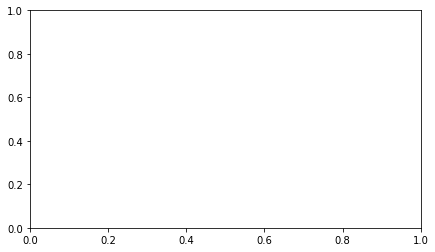

In [5]:
fig, ax = draw_plot()

# Calculate the expected sensitivity

### Assumption for NEP calculation

In [6]:
k_B = 1.380649e-23  # boltzmann const. [J/K]
Trx = 50 # Trx # DSB Trx is < 100K  for Nagoya SIS mixer from ミリ波受信機ワークショップ
dnu = (200. * 1.e+9) * 1.e-6 # Peak width [Hz]
Tload = 50 # Maximum Tload
#Tload = 100 # Tload is supposed to be 100K.
#Tload = 20 # Tload is supposed to be 20K.
#time = 60 # sec
time = 24*3600*7 # sec
#Aeff = (0.71/2.)**2*np.pi*0.5 # cm^2 # phi=0.71cm (VDI horn)
Aeff = (15/2.)**2*np.pi*0.5 # cm^2 # phi=15 cm (with mirror)
#Aeff = (30/2.)**2*np.pi*0.5 # cm^2 # phi=30 cm (with mirror)
#Aeff = (3./2.)**2*np.pi*0.5 # cm^2 # phi=3cm
#Aeff = (5./2.)**2*np.pi*0.5 # cm^2 # phi=5cm
Aeff_m = Aeff * 1.e-4 # m^2
rho_CDM = 0.3 # GeV/cm^2
alpha = np.sqrt(1./3.)

### NEP calculation

$$
\begin{align}
 T_{noise} &= T_{RX} + T_{load} \tag{5}\label{a} \\
 P_{noise} &= k_B T_{noise} \Delta \nu \tag{6}\label{b}
\end{align}
$$

<br>
<br>
$$
\begin{align}
 NEP &= \sqrt{2 P_{noise} k_B T_{noise}} \\
\mathrm{(\ref{b}) より}  &  \\
     &= \sqrt{2\Delta\nu} k_B T_{noise} \\
     &= \sqrt{2\Delta\nu} k_B (T_{rx}+T_{load}) \\
\end{align}
$$
注) $\sqrt{2}$ は $NEP$ が 0.5 sec の時間積分でのノイズを表しているため。

In [11]:
NEP = np.sqrt(2.*dnu) * k_B * (Trx + Tload) 
print(f'NEP = {NEP:e} [W/sqrt(Hz)]')

NEP = 8.731991e-19 [W/sqrt(Hz)]


## $\chi$ calculation
$$
\chi = 4.5 \times 10^{-14} 
 \left( \frac{P_{\gamma^{\prime}}}{10^{-23} \mathrm{W}} \right)^{1/2} 
 \left( \frac{1 \mathrm{m}^2}{A_{\mathrm{eff}}} \right)^{1/2} 
 \left( \frac{0.3 \mathrm{GeV/cm}^{3}}{\rho_{\mathrm{CDM,halo}}} \right)^{1/2} 
 \left( \frac{\sqrt{2/3}}{\alpha} \right)
$$

In [12]:
dP = NEP/np.sqrt(time)
chi = 4.5e-14 * np.sqrt( dP/1.e-23 *  1/Aeff_m * 0.3/rho_CDM ) * np.sqrt(2./3.) / alpha
print(f'dP = {dP:e} [W]')
print(f'chi = {chi:e}')

dP = 1.122813e-21 [W]
chi = 7.173977e-12


In [13]:
def freq_to_eV(freq_GHz): return 4.137e-6 * freq_GHz;

OSError: ./data/HPDM_by_shugo.txt not found.

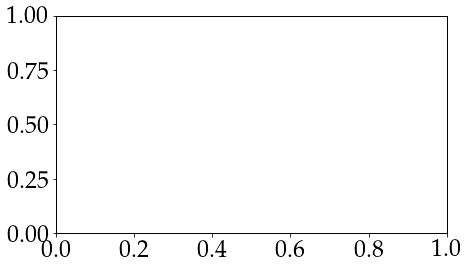

In [14]:
#drawText=True
drawText=False
fig, ax = draw_plot(drawLegend=False, drawText=drawText)

freq_min = 170. # GHz
freq_max = 260. # GHz
mass_min = freq_to_eV(freq_min)*1e+3 # meV
mass_max = freq_to_eV(freq_max)*1e+3 # meV
x = [mass_min, mass_max]
y1 = [chi, chi]
y2 = [1., 1.]

ax.fill_between(x, y1, y2, color="m", alpha=0.4)
ax.plot([mass_min,mass_min], [chi,1.], color="m")
ax.plot([mass_max,mass_max], [chi,1.], color="m")
ax.plot(x, y1, color="m")
xlim = ax.get_xlim()
ylim = ax.get_ylim()
if drawText:
    ax.text(10.**np.mean(np.log10(xlim))*0.1,5*ylim[0], f't={time} sec for each band', fontsize=14)
    ax.text(10.**np.mean(np.log10(xlim))*0.1,2*ylim[0], f'Aeff={Aeff} cm$^2$, Trx={Trx} K, Tload={Tload} K', fontsize=14)

In [ ]:
if not os.path.isdir(outdir): os.mkdir(outdir)
fig.savefig("output/constraints.pdf")

# Axion

In [15]:
h = 4.135e-15 # eV s
c = 3e+8 # m/s

def m(nu):
    return h * nu

def dnu(nu): 
    return nu*1e-6

# Tsys: system temperature [K]
# t: measurement time [s]
# nu: frequency [Hz]
def Pdet(Tsys=100, t=1e+5, nu=1e+9):
    _dnu = dnu(nu)
    _Pdet = k_B * Tsys * np.sqrt( _dnu / t )
    return _Pdet

# nu: frequency [Hz]
# B: Maget field strength [T]
# A: Dish size [m^2]
# Tsys: system temperature [K]
# t: measurement time [s]
def g(nu=10e+9, B=10, A=0.01, Tsys=100, t=1e+5):
    _dnu = dnu(nu)
    _Pdet = Pdet(Tsys, t, nu)
    _m = m(nu)
    g = 3.6e-8 * (5/B) * np.sqrt(_Pdet / 1e-23) * _m * np.sqrt(1 / A)
    return g


def g_agg(mass, C=-1.92):
    return 2e-16 * C * mass / 1e-6
# C = E/Z - 1.92
#    = -1.92 KSVZ
#    = 0.75   DFSZ I
#    = -1.25 DFSZ II
def g_agg_KSVZ(mass): return g_agg(mass, C=1.92)
def g_agg_DFSZI(mass): return g_agg(mass, C=0.75)
def g_agg_DFSZII(mass): return g_agg(mass, C=1.25)
# C_max = E/N - 1.92 (@ E/N=44/3)
def g_agg_max(mass): return g_agg(mass, C=44/3 - 1.92)
def g_agg_max2(mass): return g_agg(mass, C=170/3 - 1.92)

def add_limit(
    ax, freq_list, chi_list,
    color='r',
    lcolor='r',
    alpha=0.4,
    xscale=1.,
    zorder=None, 
    ls='-', ls_side='-',
    lw=2, lw_side=None
):
    if lw_side is None: lw_side=lw
    freq_list = np.array(freq_list)
    chi_list = np.array(chi_list)
    upper_list = np.full(len(freq_list), 1.)
    mass_list = m(freq_list) * xscale
    ax.fill_between(mass_list, chi_list, upper_list, facecolor=color, edgecolor=lcolor, alpha=alpha, zorder=zorder, lw=0, ls=ls)
    ax.plot(mass_list, chi_list, color=lcolor, lw=lw, ls=ls, zorder=zorder)
    ax.plot([mass_list[0]]*2, [chi_list[0],1.], color=lcolor, lw=lw_side, ls=ls_side, zorder=zorder)
    ax.plot([mass_list[-1]]*2, [chi_list[-1],1.], color=lcolor, lw=lw_side, ls=ls_side, zorder=zorder)
    return 0

In [16]:
# 1 GHz
print(m(1e+9)*1e+6)

print( g(nu=1e+9, A=0.01, Tsys=100) )
print( g(nu=1e+9, A=0.25, Tsys=10) )

4.135
2.765601870906241e-12
1.7491202026573361e-13


In [17]:
# 10 GHz
print(m(10e+9)*1e+6)

print( g(nu=10e+9, A=0.01, Tsys=100) )
print( g(nu=10e+9, A=0.25, Tsys=10) )

41.35
4.918012863397692e-11
3.1104244420686483e-12


In [18]:
# 260 GHz
print(m(260e+9)*1e+6)

print( g(nu=260e+9, A=0.01, Tsys=100) )
print( g(nu=260e+9, A=0.25, Tsys=10) )

1075.1000000000001
2.887395965412039e-09
1.8261495514965602e-10



5.812321696117916e-11
1.8271519011925214e-10
4.3457240821777915e-10

2.906160848058958e-11
9.135759505962607e-11
2.1728620410888958e-10

1.9374405653726386e-11
6.090506337308405e-11
1.4485746940592638e-10

1.3413050067964423e-11
4.216504387367357e-11
1.0028594035794903e-10


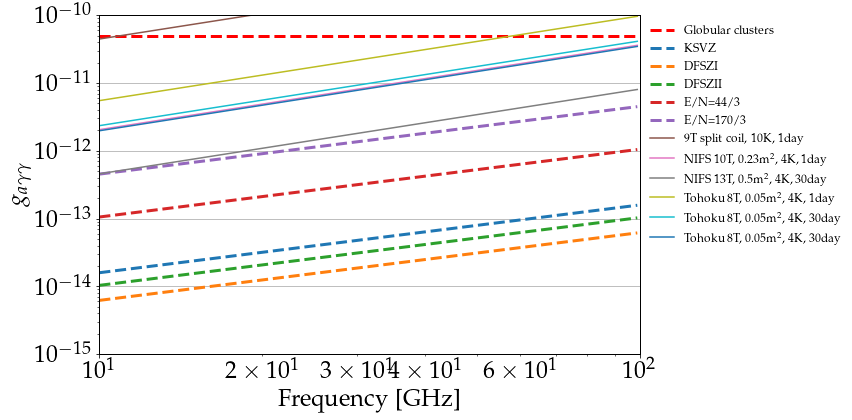

In [19]:
_freq = np.arange(10, 100, 1) * 1e+9
_freq1 = np.arange(10, 26.5, 1) * 1e+9
_freq2 = np.arange(10, 300, 1) * 1e+9

A10cm = 0.1**2
A20cm = 0.2**2
A30cm = 0.3**2
Tsys = 20

fig = plt.figure(figsize=(12, 6))
plt.plot( _freq*1e-9, np.full(len(_freq), 5e-11), c='r', ls='--', lw=3, label='Globular clusters')
plt.plot( _freq*1e-9, g_agg_KSVZ(m(_freq)), ls='--', lw=3, label='KSVZ')
plt.plot( _freq*1e-9, g_agg_DFSZI(m(_freq)), ls='--', lw=3, label='DFSZI')
plt.plot( _freq*1e-9, g_agg_DFSZII(m(_freq)), ls='--', lw=3, label='DFSZII')
plt.plot( _freq*1e-9, g_agg_max(m(_freq)), ls='--', lw=3, label='E/N=44/3')
plt.plot( _freq*1e-9, g_agg_max2(m(_freq)), ls='--', lw=3, label='E/N=170/3')

plt.plot( _freq*1e-9, g(nu=_freq, B=9, A=0.03*0.05, Tsys=10, t=1e+5), label=f'9T split coil, 10K, 1day')
'''
plt.plot( _freq*1e-9, g(nu=_freq, B=9, A=A10cm, Tsys=Tsys, t=1e+5), label=f'9T, $\phi$10cm, {Tsys}K, 1day')
plt.plot( _freq*1e-9, g(nu=_freq, B=9, A=A20cm, Tsys=Tsys, t=1e+5), label=f'9T, $\phi$20cm, {Tsys}K, 1day')
plt.plot( _freq*1e-9, g(nu=_freq, B=9, A=A30cm, Tsys=Tsys, t=1e+5), label=f'9T, $\phi$30cm, {Tsys}K, 1day')
plt.plot( _freq*1e-9, g(nu=_freq, B=13, A=A30cm, Tsys=Tsys, t=1e+5), label=f'13T, $\phi$30cm, {Tsys}K, 1day')
plt.plot( _freq*1e-9, g(nu=_freq, B=13, A=1., Tsys=Tsys, t=1e+5), label=f'13T, 1m$^2$, {Tsys}K, 1day')
plt.plot( _freq*1e-9, g(nu=_freq, B=13, A=1., Tsys=10, t=30e+5), label=f'13T, 1m$^2$, 10K, 30day')
plt.plot( _freq*1e-9, g(nu=_freq, B=13, A=1., Tsys=1, t=30e+5), label=f'13T, 1m$^2$, 1K, 30day')
plt.plot( _freq*1e-9, g(nu=_freq, B=20, A=2., Tsys=1, t=30e+5), label=f'20T, 2m$^2$, 1K, 30day')
'''
plt.plot( _freq*1e-9, g(nu=_freq, B=10, A=0.23, Tsys=4, t=1e+5), label=f'NIFS 10T, 0.23m$^2$, 4K, 1day')
plt.plot( _freq*1e-9, g(nu=_freq, B=13, A=0.5, Tsys=4, t=30e+5), label=f'NIFS 13T, 0.5m$^2$, 4K, 30day')
plt.plot( _freq*1e-9, g(nu=_freq, B=8, A=0.05, Tsys=4, t=1e+5), label=f'Tohoku 8T, 0.05m$^2$, 4K, 1day')
plt.plot( _freq*1e-9, g(nu=_freq, B=8, A=0.05, Tsys=4, t=30e+5), label=f'Tohoku 8T, 0.05m$^2$, 4K, 30day')
plt.plot( _freq*1e-9, g(nu=_freq, B=8, A=0.05, Tsys=4, t=60e+5), label=f'Tohoku 8T, 0.05m$^2$, 4K, 30day')

plt.yscale('log')
plt.xscale('log')
plt.xlim([10, 100])
plt.ylim([1e-15, 1e-10])
plt.xlabel('Frequency [GHz]')
plt.ylabel(r'$g_{a\gamma\gamma}$')
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()

print()
print( g(nu=20e+9, B=9, A=A10cm, Tsys=Tsys, t=1e+5) )
print( g(nu=50e+9, B=9, A=A10cm, Tsys=Tsys, t=1e+5) )
print( g(nu=100e+9, B=9, A=A10cm, Tsys=Tsys, t=1e+5) )
print()
print( g(nu=20e+9, B=9, A=A20cm, Tsys=Tsys, t=1e+5) )
print( g(nu=50e+9, B=9, A=A20cm, Tsys=Tsys, t=1e+5) )
print( g(nu=100e+9, B=9, A=A20cm, Tsys=Tsys, t=1e+5) )
print()
print( g(nu=20e+9, B=9, A=A30cm, Tsys=Tsys, t=1e+5) )
print( g(nu=50e+9, B=9, A=A30cm, Tsys=Tsys, t=1e+5) )
print( g(nu=100e+9, B=9, A=A30cm, Tsys=Tsys, t=1e+5) )

print()
print( g(nu=20e+9, B=13, A=A30cm, Tsys=Tsys, t=1e+5) )
print( g(nu=50e+9, B=13, A=A30cm, Tsys=Tsys, t=1e+5) )
print( g(nu=100e+9, B=13, A=A30cm, Tsys=Tsys, t=1e+5) )

## Import AxionLimit 

In [20]:
# remove unnecessary path
import sys
cwd=os.getcwd()
axionLimitPath=cwd+'/../../../AxionLimits/20240904_for_adachi'
while True:
    if sys.path.count(axionLimitPath) > 0:
        sys.path.remove(axionLimitPath)
    else:
        break
    pass
print('path=', sys.path)

path= ['/data/analysis/adachi/analysis/Limit', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/dosue/venv/env1/lib/python3.8/site-packages', '/home/dosue/venv/env1/lib/python3.8/site-packages/IPython/extensions', '/home/adachi/.ipython']


In [21]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from numpy import *
import matplotlib.pyplot as plt
import os
import sys
cwd=os.getcwd()
axionLimitPath=cwd+'/../../../AxionLimits/20240904_for_adachi'
if not os.path.isdir(axionLimitPath):
    print(f'ERROR!!: No directory! {axionLimitPath}')
    pass
print(axionLimitPath)
if not (axionLimitPath in sys.path):
    sys.path.append(axionLimitPath)
    pass
if os.path.islink('limit_data'):
    print('Unlink limit_data.')
    os.unlink('limit_data')
    pass
os.symlink(axionLimitPath+'/limit_data', 'limit_data')
print('path = ', sys.path)

from PlotFuncs import FigSetup, AxionPhoton, MySaveFig, BlackHoleSpins, FilledLimit, line_background

def drawAxionLimit(text_on=True, figsize=(16.5, 11), fontsize=25, labelfontsize=45, xtick_rotation=20, xlim=[1e-12, 1e+7], ylim=[1e-19, 1e-6],
                   frequency_axis=False, N_Hz=1e+9, xlabel=r'$m_a$ [eV]', ylabel=r'$|g_{a\gamma\gamma}|$ [GeV$^{-1}$]', xlabel_top=r'$\nu_a$ [GHz]',
                   lw=None,
                   haloscope_color=None, helioscope_color=None, cosmic_color=None, other_color=None,
                   drawStellarBounds=True, drawSolarBasin=True, drawStAB=True, drawHaloscopes=True, 
                   drawHelioscopes=True, drawLSW=True, drawLowMassAstroBounds=True, drawALPdecay=True,
                   drawNeutronStars=True, drawAxionStarExplosions=True, drawDarkMatterDecay=True,
                   drawQCDAxion=True, drawBlackHole=False, 
                   zorderHaloscope=0
                  ):
    fig,ax = FigSetup(Shape='Custom',xlab=xlabel, ylab=ylabel, upper_xlabel=xlabel_top, FrequencyAxis=frequency_axis, 
                      m_min=xlim[0], m_max=xlim[1], g_min=ylim[0], g_max=ylim[1], xtick_rotation=xtick_rotation, N_Hz=N_Hz,
                        mathpazo=True, figsize=figsize, tfs=fontsize, lfs=labelfontsize)
    
    if drawQCDAxion: AxionPhoton.QCDAxion(ax, text_on=text_on)
    if drawStellarBounds: 
        _lw = 1.5 if lw is None else lw
        if cosmic_color is None: AxionPhoton.StellarBounds(ax, text_on=text_on, lw=_lw)
        else: AxionPhoton.StellarBounds(ax, text_on=text_on, col=cosmic_color, lw=_lw)
        pass
    if cosmic_color is None:
        if drawSolarBasin: 
            if lw is None: AxionPhoton.SolarBasin(ax, text_on=text_on)
            else: AxionPhoton.SolarBasin(ax, text_on=text_on, lw=lw)
        if drawStAB: 
            if lw is None: AxionPhoton.StAB(ax, text_on=text_on)
            else: AxionPhoton.StAB(ax, text_on=text_on, lw=lw)
    else:
        if drawSolarBasin: 
            if lw is None: AxionPhoton.SolarBasin(ax, text_on=text_on, col=cosmic_color)
            else: AxionPhoton.SolarBasin(ax, text_on=text_on, col=cosmic_color, lw=lw)
        if drawStAB: 
            if lw is None: AxionPhoton.StAB(ax, text_on=text_on, col=cosmic_color)
            else: AxionPhoton.StAB(ax, text_on=text_on, col=cosmic_color, lw=lw)
        pass
    
    if haloscope_color is None:
        if drawHaloscopes: AxionPhoton.Haloscopes(ax,BASE_arrow_on=False, text_on=text_on, zorder=zorderHaloscope)
    else:
        if drawHaloscopes: AxionPhoton.Haloscopes(ax,BASE_arrow_on=False, text_on=text_on, col=haloscope_color, zorder=zorderHaloscope)
        pass
    if helioscope_color is None:
        if drawHelioscopes: AxionPhoton.Helioscopes(ax, text_on=text_on)
    else:
        if drawHelioscopes: AxionPhoton.Helioscopes(ax, text_on=text_on, col=helioscope_color)
        pass
    if drawLSW: AxionPhoton.LSW(ax, text_on=text_on)
    
    if drawLowMassAstroBounds: 
        if cosmic_color is None: AxionPhoton.LowMassAstroBounds(ax, text_on=text_on, lw=lw)
        else: AxionPhoton.LowMassAstroBounds(ax, text_on=text_on, lw=lw, col=cosmic_color)
        pass
    if drawALPdecay: AxionPhoton.ALPdecay(ax, text_on=text_on)
    if cosmic_color is None:
        if drawNeutronStars:    
            if lw is None: AxionPhoton.NeutronStars(ax, text_on=text_on)
            else: AxionPhoton.NeutronStars(ax, text_on=text_on, lw=lw)
            pass
        if drawAxionStarExplosions:  
            if lw is None: AxionPhoton.AxionStarExplosions(ax, text_on=text_on)
            else: AxionPhoton.AxionStarExplosions(ax, text_on=text_on, lw=lw)
            pass
        if drawDarkMatterDecay: AxionPhoton.DarkMatterDecay(ax, text_on=text_on)
        if drawBlackHole: BlackHoleSpins(ax,(1/137)*(1/(2*pi)),[1.5e-12,0.5e-17],rotation=-90,alpha=1,fs=18,facecolor=[0.7,0.7,0.7],whichfile='Baryakhtar')
    else:
        if drawNeutronStars:    
            if lw is None: AxionPhoton.NeutronStars(ax, text_on=text_on, col=cosmic_color)
            else: AxionPhoton.NeutronStars(ax, text_on=text_on, col=cosmic_color, lw=lw)
            pass
        if drawAxionStarExplosions:  
            if lw is None: AxionPhoton.AxionStarExplosions(ax, text_on=text_on, col=cosmic_color)
            else: AxionPhoton.AxionStarExplosions(ax, text_on=text_on, col=cosmic_color, lw=lw)
            pass
        if drawDarkMatterDecay:AxionPhoton.DarkMatterDecay(ax, text_on=text_on)
        if drawBlackHole: BlackHoleSpins(ax,(1/137)*(1/(2*pi)),[1.5e-12,0.5e-17],rotation=-90,alpha=1,fs=18,facecolor=cosmic_color,whichfile='Baryakhtar')
        pass
    
    ''' 上の x 軸の tick format を変えたい(ができなかった)
    ax2 = ax.twiny()
    xticks2 = ax2.get_xticks()
    print(xticks2)
    xlabels2 = [ f'{_x:g}' for _x in xticks2 ]
    print(xlabels2)
    ax2.set_xticks(xticks2, labels=xlabels2)
    '''
    
    return fig, ax

/data/analysis/adachi/analysis/Limit/../../../AxionLimits/20240904_for_adachi
Unlink limit_data.
path =  ['/data/analysis/adachi/analysis/Limit', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/dosue/venv/env1/lib/python3.8/site-packages', '/home/dosue/venv/env1/lib/python3.8/site-packages/IPython/extensions', '/home/adachi/.ipython', '/data/analysis/adachi/analysis/Limit/../../../AxionLimits/20240904_for_adachi']


## With Expectation Black & White

['$10^0$', '$10^1$', '$10^2$', '$10^3$', '$10^4$', '$10^5$']


(1e-05, 0.003)

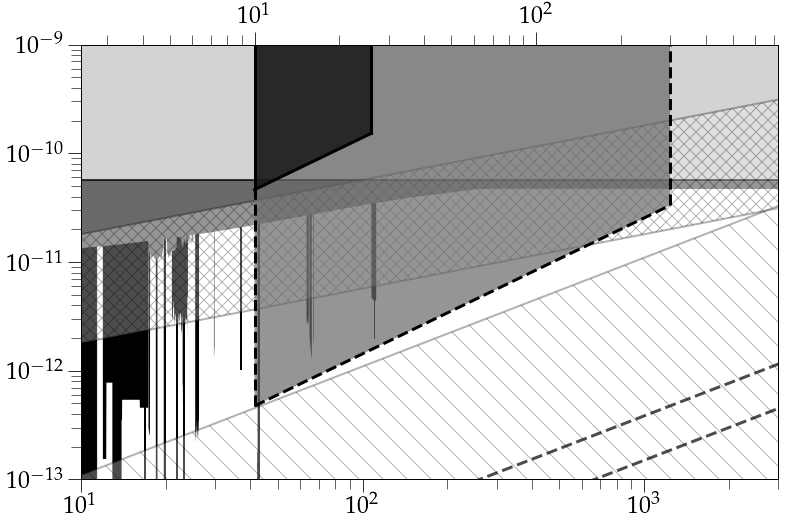

In [39]:
xlim = [1e-5, 3e-3]
fig, ax = drawAxionLimit(text_on=False, drawQCDAxion=False, drawBlackHole=False, 
                         figsize=(12.5, 8), fontsize=24, labelfontsize=30, 
                         xlim=xlim, ylim=[1e-13, 1e-9], frequency_axis=True, xtick_rotation=0,
                         xlabel='', ylabel='', xlabel_top='', lw=0,
                         cosmic_color='dimgray', helioscope_color='lightgray', haloscope_color='black',
                         drawStellarBounds=True, drawSolarBasin=True, drawStAB=True, drawHaloscopes=True, 
                         drawHelioscopes=True, drawLSW=True, drawLowMassAstroBounds=True, drawALPdecay=True,
                         drawNeutronStars=True, drawAxionStarExplosions=True, drawDarkMatterDecay=True,
                         zorderHaloscope=-100,
                        )

# Theory
_x = np.power(10, np.linspace(-6, 0, 61))
# QCD axion
#ax.plot( _x, g_agg_max(_x), ls=':', lw=3, label='E/N=44/3', c='orange')
ax.plot( _x, g_agg_KSVZ(_x), ls='--', lw=3, label='KSVZ', c='k')
ax.plot( _x, g_agg_DFSZI(_x), ls='--', lw=3, label='DFSZI', c='k')
#ax.plot( _x, g_agg_DFSZII(_x), ls=':', lw=3, label='DFSZII', c='orange')
#ax.plot( _x, g_agg_max2(_x), ls=':', lw=5, label='E/N=170/3', c='orange')
ax.fill_between(_x, np.full(len(_x), 0.), g_agg_max2(_x), color='white', edgecolor='k', alpha=0.3, zorder=200, lw=2, ls='-', hatch='\\')
# ALP cogenesis
_ALP1 = 1.8e-11*np.sqrt(_x*1e+3)
_ALP2 = 1.8e-10*np.sqrt(_x*1e+3)
ax.fill_between(_x, _ALP1, _ALP2, color='white', edgecolor='k', alpha=0.3, zorder=100, lw=2, ls='-', hatch='xx')


# Add my limits
#  label=f'9T split coil, 10K, 1 day'
add_limit( ax, _freq1, g(nu=_freq1, B=9, A=0.03*0.05, Tsys=10, t=3600*24*1), 
          color='k', lcolor='k', alpha=0.7, xscale=1., zorder=1000, lw=3, lw_side=3, ls='-', ls_side='-')
# label=f'NIFS 13T, 0.5m$^2$, 4K, 30day'
add_limit( ax, _freq2, g(nu=_freq2, B=13, A=0.5, Tsys=4, t=3600*24*30), 
          color='dimgray', lcolor='k', alpha=0.7, xscale=1., zorder=300, lw=3, lw_side=3, ls='--', ls_side='--')


import matplotlib.ticker as ticker
yticks = ax.get_yticks()
xticks = ax.get_xticks()
#xlabels = [ f'{_x:g}' for _x in xticks*1.e+6 ]
xlabels = [ f'$10^{int(np.log10(_x))}$' for _x in xticks*1.e+6 ]
print(xlabels)
ax.set_xticks(xticks, labels=xlabels)
#ax.set_xlabel('$m_a$ [$\mu$eV]')

#from matplotlib.ticker import ScalarFormatter
#ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#ax.ticklabel_format(style="sci",  axis="x",scilimits=(0,0))
#ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
#ax.set_xticks(xticks, xticks*1e+6, fontsize=30, rotation=0)
#ax.set_yticklabels(yticks, fontsize=30)
#ax.xaxis.set_major_formatter('{x}')

ax.set_xlim(xlim)

## Without Expectation Black & White

['$10^0$', '$10^1$', '$10^2$', '$10^3$', '$10^4$', '$10^5$']


(1e-05, 0.003)

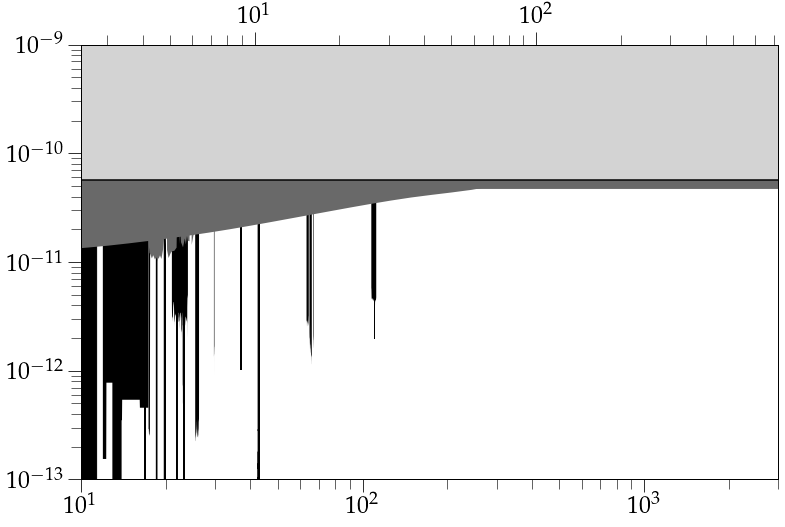

In [41]:
fig, ax = drawAxionLimit(text_on=False, drawQCDAxion=False, drawBlackHole=False, 
                         figsize=(12.5, 8), fontsize=24, labelfontsize=30, 
                         xlim=xlim, ylim=[1e-13, 1e-9], frequency_axis=True, xtick_rotation=0,
                         xlabel='', ylabel='', xlabel_top='', lw=0,
                         cosmic_color='dimgray', helioscope_color='lightgray', haloscope_color='black',
                         drawStellarBounds=True, drawSolarBasin=True, drawStAB=True, drawHaloscopes=True, 
                         drawHelioscopes=True, drawLSW=True, drawLowMassAstroBounds=True, drawALPdecay=True,
                         drawNeutronStars=True, drawAxionStarExplosions=True, drawDarkMatterDecay=True,
                         zorderHaloscope=-100,
                        )

'''
# Theory
_x = np.power(10, np.linspace(-6, 0, 61))
# QCD axion
#ax.plot( _x, g_agg_max(_x), ls=':', lw=3, label='E/N=44/3', c='orange')
ax.plot( _x, g_agg_KSVZ(_x), ls='--', lw=3, label='KSVZ', c='k')
ax.plot( _x, g_agg_DFSZI(_x), ls='--', lw=3, label='DFSZI', c='k')
#ax.plot( _x, g_agg_DFSZII(_x), ls=':', lw=3, label='DFSZII', c='orange')
#ax.plot( _x, g_agg_max2(_x), ls=':', lw=5, label='E/N=170/3', c='orange')
ax.fill_between(_x, np.full(len(_x), 0.), g_agg_max2(_x), color='white', edgecolor='k', alpha=0.3, zorder=200, lw=2, ls='-', hatch='\\')
# ALP cogenesis
_ALP1 = 1.8e-11*np.sqrt(_x*1e+3)
_ALP2 = 1.8e-10*np.sqrt(_x*1e+3)
ax.fill_between(_x, _ALP1, _ALP2, color='white', edgecolor='k', alpha=0.3, zorder=100, lw=2, ls='-', hatch='xx')
'''


yticks = ax.get_yticks()
xticks = ax.get_xticks()
#xlabels = [ f'{_x:g}' for _x in xticks*1.e+6 ]
xlabels = [ f'$10^{int(np.log10(_x))}$' for _x in xticks*1.e+6 ]

print(xlabels)
ax.set_xticks(xticks, labels=xlabels)
ax.set_xlim(xlim)
#ax.set_xlabel('$m_a$ [$\mu$eV]')

## With Expectation Color

In [ ]:
xlim = [1e-5, 3e-3]
fig, ax = drawAxionLimit(text_on=False, drawQCDAxion=False, drawBlackHole=False, 
                         figsize=(12.5, 8), fontsize=24, labelfontsize=30, 
                         xlim=xlim, ylim=[1e-13, 1e-9], frequency_axis=True, xtick_rotation=0,
                         xlabel='', ylabel='', xlabel_top='', lw=0,
                         cosmic_color='darkgreen', helioscope_color='navy', haloscope_color='maroon',
                         drawStellarBounds=True, drawSolarBasin=True, drawStAB=True, drawHaloscopes=True, 
                         drawHelioscopes=True, drawLSW=True, drawLowMassAstroBounds=True, drawALPdecay=True,
                         drawNeutronStars=True, drawAxionStarExplosions=True, drawDarkMatterDecay=True,
                         zorderHaloscope=-100,
                        )

# Theory
_x = np.power(10, np.linspace(-6, 0, 61))
# QCD axion
#ax.plot( _x, g_agg_max(_x), ls=':', lw=3, label='E/N=44/3', c='orange')
ax.plot( _x, g_agg_KSVZ(_x), ls='-', lw=3, label='KSVZ', c='maroon')
ax.plot( _x, g_agg_DFSZI(_x), ls='-', lw=3, label='DFSZI', c='maroon')
#ax.plot( _x, g_agg_DFSZII(_x), ls=':', lw=3, label='DFSZII', c='orange')
#ax.plot( _x, g_agg_max2(_x), ls=':', lw=5, label='E/N=170/3', c='orange')
ax.fill_between(_x, np.full(len(_x), 0.), g_agg_max2(_x), color='orange', edgecolor='darkorange', alpha=0.3, zorder=200, lw=2, ls='--', hatch='')
# ALP cogenesis
_ALP1 = 1.8e-11*np.sqrt(_x*1e+3)
_ALP2 = 1.8e-10*np.sqrt(_x*1e+3)
ax.fill_between(_x, _ALP1, _ALP2, color='orange', edgecolor='darkorange', alpha=0.3, zorder=100, lw=2, ls='--', hatch='')


# Add my limits
#  label=f'9T split coil, 10K, 1 day'
add_limit( ax, _freq1, g(nu=_freq1, B=9, A=0.03*0.05, Tsys=10, t=3600*24*1), 
          #color='red', lcolor='r', alpha=0.7, xscale=1., zorder=1000, lw=3, lw_side=3, ls='--', ls_side='--')
          color='red', lcolor='r', alpha=0.8, xscale=1., zorder=1000, lw=3, lw_side=3, ls='--', ls_side='--')
# label=f'NIFS 13T, 0.5m$^2$, 4K, 30day'
add_limit( ax, _freq2, g(nu=_freq2, B=13, A=0.5, Tsys=4, t=3600*24*30), 
          color='red', lcolor='r', alpha=0., xscale=1., zorder=300, lw=5, lw_side=5, ls='--', ls_side='--')


import matplotlib.ticker as ticker
yticks = ax.get_yticks()
xticks = ax.get_xticks()
#xlabels = [ f'{_x:g}' for _x in xticks*1.e+6 ]
xlabels = [ f'$10^{int(np.log10(_x))}$' for _x in xticks*1.e+6 ]
print(xlabels)
ax.set_xticks(xticks, labels=xlabels)
#ax.set_xlabel('$m_a$ [$\mu$eV]')

#from matplotlib.ticker import ScalarFormatter
#ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#ax.ticklabel_format(style="sci",  axis="x",scilimits=(0,0))
#ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
#ax.set_xticks(xticks, xticks*1e+6, fontsize=30, rotation=0)
#ax.set_yticklabels(yticks, fontsize=30)
#ax.xaxis.set_major_formatter('{x}')

ax.set_xlim(xlim)

## Without Expectation Black & White

['$10^0$', '$10^1$', '$10^2$', '$10^3$', '$10^4$', '$10^5$']


(1e-05, 0.003)

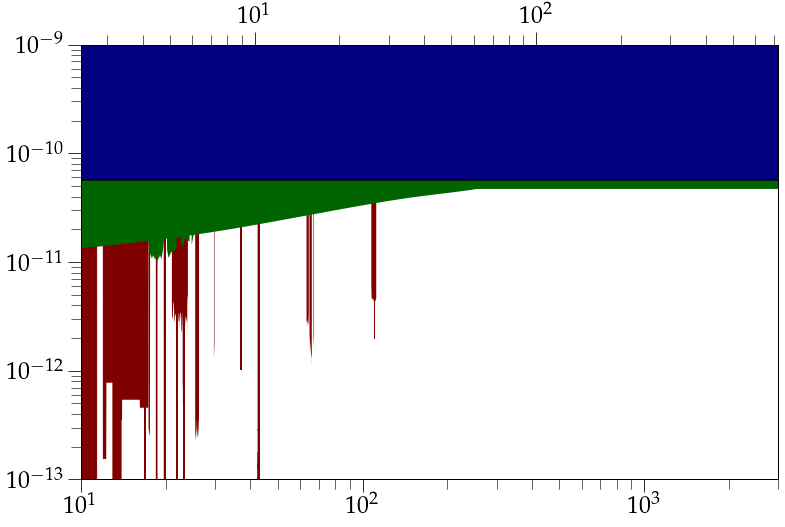

In [56]:
fig, ax = drawAxionLimit(text_on=False, drawQCDAxion=False, drawBlackHole=False, 
                         figsize=(12.5, 8), fontsize=24, labelfontsize=30, 
                         xlim=xlim, ylim=[1e-13, 1e-9], frequency_axis=True, xtick_rotation=0,
                         xlabel='', ylabel='', xlabel_top='', lw=0,
                         cosmic_color='darkgreen', helioscope_color='navy', haloscope_color='maroon',
                         drawStellarBounds=True, drawSolarBasin=True, drawStAB=True, drawHaloscopes=True, 
                         drawHelioscopes=True, drawLSW=True, drawLowMassAstroBounds=True, drawALPdecay=True,
                         drawNeutronStars=True, drawAxionStarExplosions=True, drawDarkMatterDecay=True,
                         zorderHaloscope=-100,
                        )

'''
# Theory
_x = np.power(10, np.linspace(-6, 0, 61))
# QCD axion
#ax.plot( _x, g_agg_max(_x), ls=':', lw=3, label='E/N=44/3', c='orange')
ax.plot( _x, g_agg_KSVZ(_x), ls='--', lw=3, label='KSVZ', c='k')
ax.plot( _x, g_agg_DFSZI(_x), ls='--', lw=3, label='DFSZI', c='k')
#ax.plot( _x, g_agg_DFSZII(_x), ls=':', lw=3, label='DFSZII', c='orange')
#ax.plot( _x, g_agg_max2(_x), ls=':', lw=5, label='E/N=170/3', c='orange')
ax.fill_between(_x, np.full(len(_x), 0.), g_agg_max2(_x), color='white', edgecolor='k', alpha=0.3, zorder=200, lw=2, ls='-', hatch='\\')
# ALP cogenesis
_ALP1 = 1.8e-11*np.sqrt(_x*1e+3)
_ALP2 = 1.8e-10*np.sqrt(_x*1e+3)
ax.fill_between(_x, _ALP1, _ALP2, color='white', edgecolor='k', alpha=0.3, zorder=100, lw=2, ls='-', hatch='xx')
'''


yticks = ax.get_yticks()
xticks = ax.get_xticks()
#xlabels = [ f'{_x:g}' for _x in xticks*1.e+6 ]
xlabels = [ f'$10^{int(np.log10(_x))}$' for _x in xticks*1.e+6 ]

print(xlabels)
ax.set_xticks(xticks, labels=xlabels)
ax.set_xlim(xlim)
#ax.set_xlabel('$m_a$ [$\mu$eV]')